# Introduction to XRD Analysis in Python

So far you have been introduced to the python programming language, working with arrays, importing data, and doing simple curve fitting. In this video we are going to apply those skills to the study of X-Ray Diffraction data to determine lattice spacing and peak intensity. 

After this video you should be able to:
* Plot XRD data as a function of 2-theta or Q
* Trim data to look at specific X-ray diffraction peaks 
* Remove a simple background
* Determine lattice spacing and intensity using guassian peak fitting

We'll be using the same imports as our previous tutorials with one important additions. We'll be adding pandas, a powerful data analysis library that makes it very easy for us to import our data. 

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize 
import pandas as pd

## Importing the Data
For this tutorial I already have a datafile of xrd data. This datafile is stacked .csv where the first column is the valuse of 2-theta and susequent columns are diffracted intensity for a variety of samples. 

To import the data we're going to define a function "readcsv" which will use the read_csv function built into pandas to pull the data, and then convert it to a numpy array since we're already familiar with working with those.. 

In [7]:
def readcsv(filename):
    data = pd.read_csv(filename)
    return(np.array(data))

perov = readcsv('D1_MAPBIBr2_Xraydeg.csv') #this is a test piece of data stored in our repository
#you could read data in from a file in a different folder, provided you include the directory in the file name

We've now created a 2D array called perov that contains all of the data that was in this csv file. To confirm it's imported correctly we'll go ahead and plot the data, but before we do that let's take a second to go over the syntax of 2D arrays.


In [11]:
#first let's make a 2D array of integers
two_d = np.array([[1, 2, 3], [4, 5, 6]]) #this syntax will give us a an array with two rows and three columns

In [12]:
#now let's access some elements of this array.
print(two_d[0,0]) #to get a single element we use single integers corresponsing to the row and column position

#we can also get all the elements of a row or column using the ':' symbol. 
print(two_d[:,0]) #print all elements in the first column of our array
print(two_d[0,:]) #print all elements in the top row of our array

1
[1 4]
[1 2 3]


With that syntax in mind, we can go ahead and plot our data. We want to plot column one of our 2D array (our 2-theta values) against the our X-ray diffraction intensities (the values in any other column)

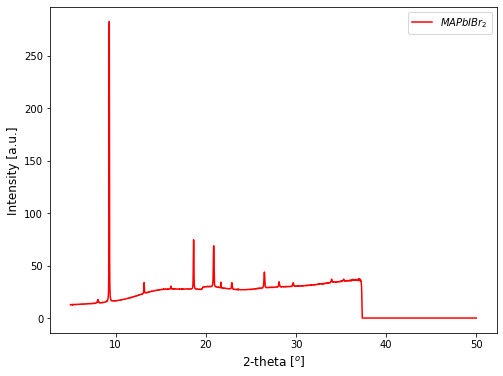

In [21]:
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(perov[:,0],perov[:,1],'r-', label='$MAPbIBr_2$') #plot two-theta versus XRD intesntiy
plt.xlabel('2-theta [$^o$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

### Exercise 1 
To test your import and plotting skills go ahead and write a piece of code that will plot the first and last frames of XRD data from the csv we imported in the same figure. 

## Converting from 2-theta to Q
The data we've imported has 2-theta as the independent variable. However, we'd prefer to look at our data with respect to Q. To this conversion, we need to tap into our knowledge of Bragg's law and recirpical lattice spacing (a.k.a. Q). 

From the Bragg condition (assuming $n=1$):
 $$ \lambda = 2d\sin(\theta)$$ 
 
Definition of Q:
$$Q=\frac{2\pi}{d}$$

And combining those two equations we have:
$$Q = \frac{4\pi\sin(\theta)}{\lambda}$$

In [85]:
#We know what to execute this conversion, making note that our initial 2-theta values are in degrees, not radians
#We also need to define the X-ray wavelength we're using
wave = 0.9763 #wavelength used at SSRL in Angstroms
theta = perov[:,0]/2*np.pi/180 #convert from 2-theta to theta in radians
q = 4*np.pi*np.sin(theta)/wave #convert to q

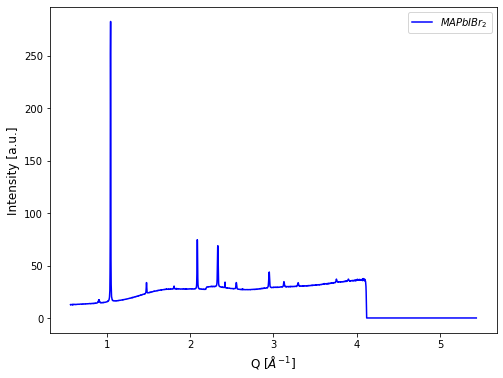

In [86]:
#We can now check that our conversion went as expected by ploting our data versus q
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q,perov[:,1],'b-', label='$MAPbIBr_2$') #plot Q versus XRD intesntiy
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

### Exercise 2
This is a process we'd like to do every time we open a piece of XRD data. Given that, it's worthwhile to make a function that will do this conversion for us. Go ahead and write a function that takes in an array of 2-theta values and a X-ray wavelength $\lambda$, and returns an array of Q values. 

## Trimming the Data
Now that we've gone ahead and confirmed that our data makes sense, we're going to start getting the data in a format that we can easily fit. This involves trimming the data and substracting the background, such that we isolate a single peak we'll be able to fit. We'll then use the result of that fit to go back and analyze the full data set.

Trimming the data involves picking a narrower range of Q values that we want to look at, ideally to isolate a single peak. We'll try to isolate the first large peak in our data set since that is likely to be the (100). We'll go ahead and confirm this later by attempting to index all the peaks using the lattice spacing we derive making that guess.

To trim the data we want to set some limits, and then determine the index that is closest to those valuse, so we can then reference those when calling some segment of our array.

In [87]:
#To trim our data, we want to be able to set limit values - we'll keep the data inside these limits
#We'll define a function that returns the index of the value in our array, closest to the limit we've set...
#since we're not guarenteed to have a value of exactly 0.98 in our data
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

q_1 = 0.98 #This will be the lower limit for Q we'll consider
q_2 = 1.15 #This will be our upper limit - ideally there is only one peak between these values

#We use our new function to find the index of real value closest to our desired limit
limit1 = find_nearest(q, q_1) #First our lower limit
limit2 = find_nearest(q, q_2) #And of our higher limit

In [88]:
#Having extablished our limits we can now trim the data
q_sub = q[limit1:limit2] #We'll reduce the domain of Q
perov_sub = perov[limit1:limit2,1:-1] #And correspondingly shrink the size of our diffraction data set. 
#You'll also notice I'm dropping the first column of data in the perov array, since that's now accounted for in q_sub

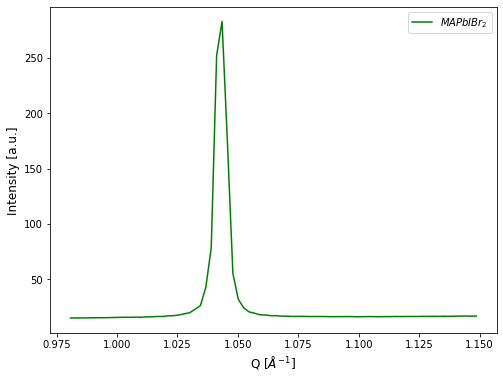

In [89]:
#Now let's go ahead and plot again to see if our trimming worked
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_sub[:,0],'g-', label='$MAPbIBr_2$') #plot subfield of data
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

## Substracting Background
We're almost ready to analyze our! Our last step is to remove the background - the XRD intensity not resulting from diffraction. When we collect the data, while are brightest signal comes from diffracted intensity, there are a bunch of other X-rays bouncing around the chamber that are being collected by our detector. These result a non-zero baseline for our XRD intesntiy. Removing this background will allow us more accurately fit our data. 

While the background intensity is relatively complicated in shape, in our little subset it looks more or less like a flat line. We can there treat it as such for our subset of data. 

In [90]:
#Using the linear fitting introduced in exercise 03, let's fit a straight line for the data around our peak.
#For total transparency this method could be MUCH MUCH better. Open to suggestions!
q_linear = [np.mean(q_sub[0:10]), np.mean(q_sub[-10:-1])] #I'm taking the mean of my starting and ending values 
perov_linear = [np.mean(perov_sub[0:10,0]), np.mean(perov_sub[-10:-1,0])] #We'll use these to fit a straight line
pfit = np.polyfit(q_linear, perov_linear, 1) #Do linear fit
back = pfit[0]*q_sub+pfit[1] #Create background array of the form back = AX+B

### Exercise 3
To test the validity of our approach, it is again a good idea to plot our data and plot the background. Create a plot that includes our experimental data, the predicted background, and the data with the background substracted.

## Peak Fitting
We've finally made it to the point where we can analyze our data. In order to determine lattice parameter and peak intensity, we want to fit our experimental data to an idealized model. That model is a guassian peak, which is described bt the following expression:

$$f(x)=ae^{\frac{-(x-b)^2}{2c^2}}$$

Where $a$ is the height of the peak, $b$ is the peak's center, and $c$ is the standard deviation which impacts the width of the peak. For our XRD analysis, $a$ will tell us about the crystallinity of our film, $c$ will tell us the crystallite size or crystal strain, and $b$ will tell us the lattice spacing. 

We'll again use scipy.optimize.curve_fit to pull these parameters from our data set. 

In [91]:
#Let's begin by getting our data ready to analyze
perov_fit = perov_sub[:,0]-back #We'll begin by subtracting the background we calculated for this piece of data

#Now let's define a function we'll want to fit to - this is analagous to the "straight-line-model" from tutorial 03
#We'll call our function gaussian and it will calculate the expression described above
def gaussian(x, a, b, c): 
    return a*np.exp(-(x - b)**2/(2*c**2))

#We'll also give an initial guess for our fits based off of a visual interpretaion of our data
p0 = [250, 1, 0.2]

#Use scipy.optimize.curve_fit to fit our desired data
popt, pcov = curve_fit(gaussian, q_sub, perov_fit, p0)


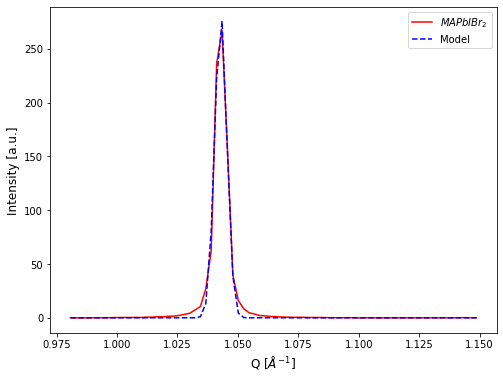

In [92]:
#To confirm our fits it's always nice to plot our model versus our data.
plt.figure(figsize=(8,6)) #make plot larger
plt.plot(q_sub,perov_fit,'r-', label='$MAPbIBr_2$') #plot subfield of data
plt.plot(q_sub,gaussian(q_sub, *popt),'b--', label='Model') #plot best fit
plt.xlabel('Q [$\AA^{-1}$]',size=12) #Define x-axis label
plt.ylabel('Intensity [a.u.]',size=12)#Define y-axis label
plt.legend(loc="upper right")#Put legend in upper left hand corner

In [93]:
#With confidence in our fit we can now go ahead and print/make note of/tabulate our parameters of interest. 
#Print peak intensity
print('Intensity:', popt[0])

#Caculate and pring d-spacing
d = 2*np.pi/popt[1] #Applying d = 2*pi/Q
print('d-Spacing: ', d) 

#Print lattice constant
miller = [1, 0, 0] #need to guess miller inidices of peak
a = d/np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2) #calculate a using a = d/sqrt(h^2+k^2+l^2) for a cubic lattice
print('Lattice Spacing:', a)

Intensity: 281.4823351386081
d-Spacing:  6.024424091409692
Lattice Spacing: 6.024424091409692


### Exercise 4
Using this lattice parameter, write a piece of code that will predict the location of all the other peaks (i.e those corresponding to the (110), (111), (200), etc.) Make a plot of overlaying your predictions on the acutal data. How well do they compare? Can you come up with a way of quantifying the discrepency between your prediction and actual peak posisitions?

### Exercise 5
Instead of fitting to the (100) peak, we'll often look at the (200) peak for better resolution. Create a new piece of code that succesfully finds the lattice parameter using the (200) peak instead. Repeat the analysis you did for exercise 4 - do you have a more accurate prediction using the (200) peak? Note, you will have to update your data limits for this to run succesfully. 